In [1]:
# imports

# standard import of pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Floats (decimal numbers) should be displayed rounded with 2 decimal places
pd.options.display.float_format = "{:,.2f}".format
# Set style for plots
plt.style.use('fivethirtyeight') 

In [3]:
# getting dataframe

%store -r final_merge
%store -r lead_time

### Pickup Waiting time = time between ready_to_be_shipped & pickup_date)

In [4]:
final_merge.sample(2)

,order_id,order_date,state,region,ship_mode,ready_to_ship_date,pickup_date,arrival_scan_date
1883,CA-2019-118570,2019-11-13,Pennsylvania,East,Standard Processing,NaT,2019-11-20,NaT
395,CA-2017-108903,2017-10-03,Ohio,East,Express,NaT,NaT,NaT


In [5]:
# Create new data frame
pickup_waiting = final_merge.copy()

## keep only necessary columns
pickup_waiting = pickup_waiting.filter(items=["state", "region", "order_date", "ready_to_ship_date", "pickup_date"]).copy()
pickup_waiting.head(1)

,state,region,order_date,ready_to_ship_date,pickup_date
0,California,West,2019-01-16,NaT,2019-01-23


In [6]:
# Drop rows if there are null values in column arrival scan date
pickup_waiting.dropna(subset=['pickup_date'], inplace=True)

# Same for read to be shipped
pickup_waiting.dropna(subset=['ready_to_ship_date'], inplace=True)

In [7]:
# show me no. of cells that ARE NULL
pickup_waiting['ready_to_ship_date'].isnull().sum()

# show me no. of cells that ARE NULL
pickup_waiting['pickup_date'].isnull().sum()

0

In [8]:
pickup_waiting['ready_to_ship_date'].isnull().sum()
pickup_waiting.shape

(204, 5)

In [9]:
# Calculate time between Ready to be shipped & Pickup date
pickup_waiting["waiting_for_pickup"] = pickup_waiting["pickup_date"] - pickup_waiting["ready_to_ship_date"]

# Display new column waiting_for_pickup and results 
pickup_waiting["waiting_for_pickup"]

8      2 days
17     1 days
41     0 days
80     2 days
95     1 days
        ...  
4852   2 days
4859   1 days
4913   1 days
4997   1 days
5003   2 days
Name: waiting_for_pickup, Length: 204, dtype: timedelta64[ns]

In [10]:
# Create new column for Days in INT format in case we need this for calculating
pickup_waiting["waiting_for_pickup_i"] = pickup_waiting["waiting_for_pickup"].dt.days
pickup_waiting.head(5)

,state,region,order_date,ready_to_ship_date,pickup_date,waiting_for_pickup,waiting_for_pickup_i
8,North Carolina,South,2020-11-23,2020-11-30,2020-12-02,2 days,2
17,California,West,2019-09-11,2019-09-17,2019-09-18,1 days,1
41,Missouri,Central,2020-11-26,2020-11-27,2020-11-27,0 days,0
80,New York,East,2019-09-06,2019-09-09,2019-09-11,2 days,2
95,Arizona,West,2020-11-10,2020-11-11,2020-11-12,1 days,1


### What is the avg. no of days waiting for pickup?

In [11]:
# describe  the data 
pickup_waiting["waiting_for_pickup_i"].describe()

# Avg waiting time for pickup is 2 days
# max is 3 days
# min is 1 day

count   204.00
mean      1.57
std       0.95
min       0.00
25%       1.00
50%       2.00
75%       2.00
max       3.00
Name: waiting_for_pickup_i, dtype: float64

pickup_waiting["waiting_for_pickup_i"].mode()


### How many orders went over the 2 day time frame?

In [12]:
# show me data where orders waited 3 days for pickup
# We have 34 cases from 204 orders, that were 

filt_pickup_waiting = pickup_waiting.loc[pickup_waiting['waiting_for_pickup_i'] >= 3]
filt_pickup_waiting.count()

state                   34
region                  34
order_date              34
ready_to_ship_date      34
pickup_date             34
waiting_for_pickup      34
waiting_for_pickup_i    34
dtype: int64

### Are there days that cause some orders to take 3 days before being picked up?

In [13]:
pickup_waiting["ready_ship_day"] = pickup_waiting["ready_to_ship_date"].dt.day_name()
pickup_waiting["pickup_day"] = pickup_waiting["pickup_date"].dt.day_name()
pickup_waiting["order_day"] = pickup_waiting["order_date"].dt.day_name()

pickup_waiting.head(1)

,state,region,order_date,ready_to_ship_date,pickup_date,waiting_for_pickup,waiting_for_pickup_i,ready_ship_day,pickup_day,order_day
8,North Carolina,South,2020-11-23,2020-11-30,2020-12-02,2 days,2,Monday,Wednesday,Monday


In [14]:
# Show me all rows with 3 days or more
filt_pickup_waiting2 = pickup_waiting.loc[pickup_waiting['waiting_for_pickup_i'] >= 3]

# count number of ready_ship_day values for each occurance
total_ready_ship_days = filt_pickup_waiting2['ready_ship_day'].value_counts()

# count number of ready_ship_day values for each occurance
total_order_days = filt_pickup_waiting2['order_day'].value_counts()

# count occurance for each region that appears to see if there are any correlations
region_counts = filt_pickup_waiting2['region'].value_counts()

#print("Filtered Rows:")
print("\nOrder Days:", total_order_days)
print("\nTotal Ready Ship Days:", total_ready_ship_days)
print("\nRegion Counts:")
print(region_counts)


Order Days: order_day
Monday       11
Saturday      7
Tuesday       6
Friday        5
Wednesday     4
Thursday      1
Name: count, dtype: int64

Total Ready Ship Days: ready_ship_day
Friday    22
Monday    12
Name: count, dtype: int64

Region Counts:
region
West       12
South      10
East        9
Central     3
Name: count, dtype: int64


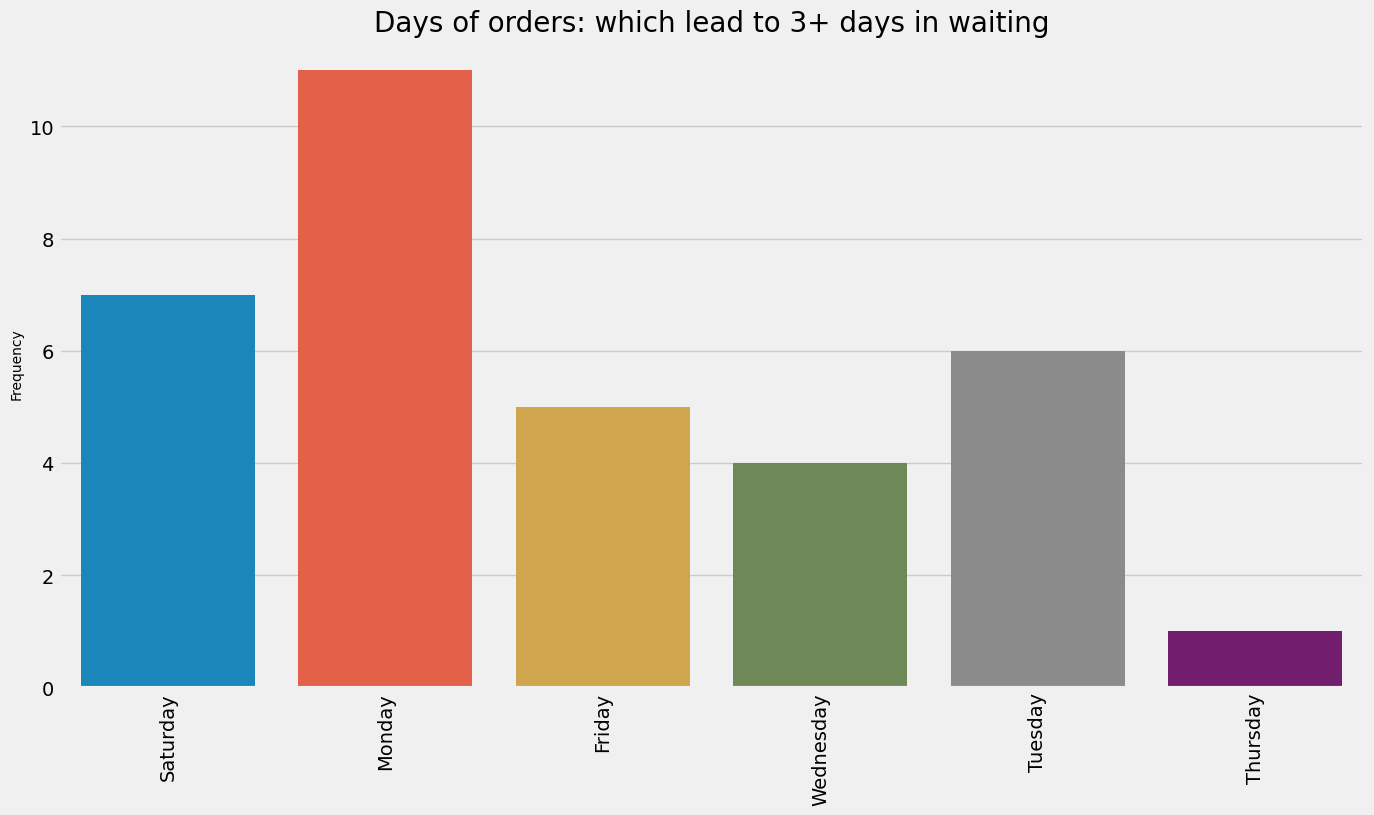

In [15]:
# SINGLE PLOT - DAYS OF ORDERS
plt.figure(figsize=(15,8)) # specify figure size
f1 = sns.countplot(x=filt_pickup_waiting2['order_day']) # create countplot
f1.tick_params(axis='x', rotation=90) # get x-ticks and rotate them
f1.set(xlabel=None) # set no label for x-axis 
f1.set_ylabel("Frequency", fontsize = 10); # set label for y-axis
f1.set_title('Days of orders: which lead to 3+ days in waiting', fontsize=20); # set title

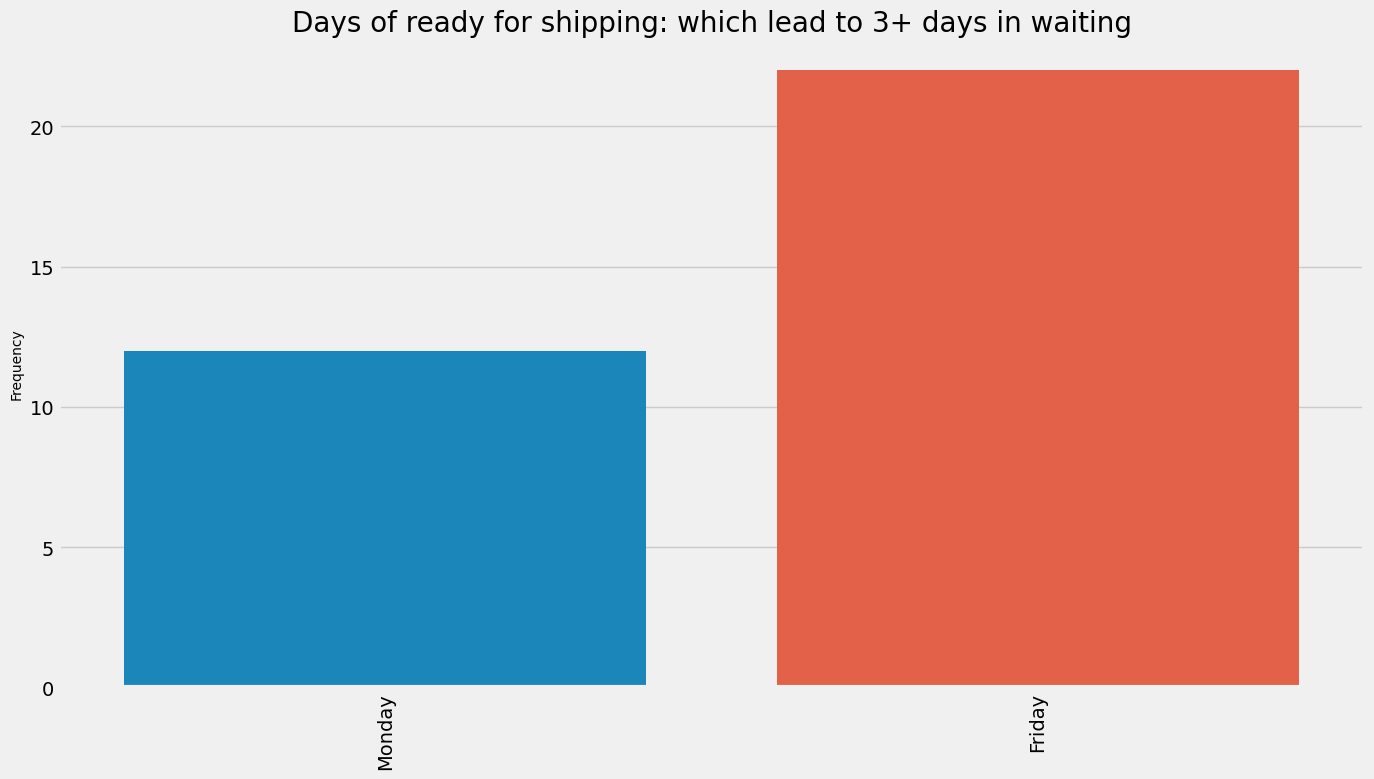

In [16]:
# SINGLE PLOT - DAYS OF READY FOR SHIPPING
plt.figure(figsize=(15,8)) # specify figure size
f1 = sns.countplot(x=filt_pickup_waiting2['ready_ship_day']) # create countplot
f1.tick_params(axis='x', rotation=90) # get x-ticks and rotate them
f1.set(xlabel=None) # set no label for x-axis 
f1.set_ylabel("Frequency", fontsize = 10); # set label for y-axis
f1.set_title('Days of ready for shipping: which lead to 3+ days in waiting', fontsize=20); # set title

''

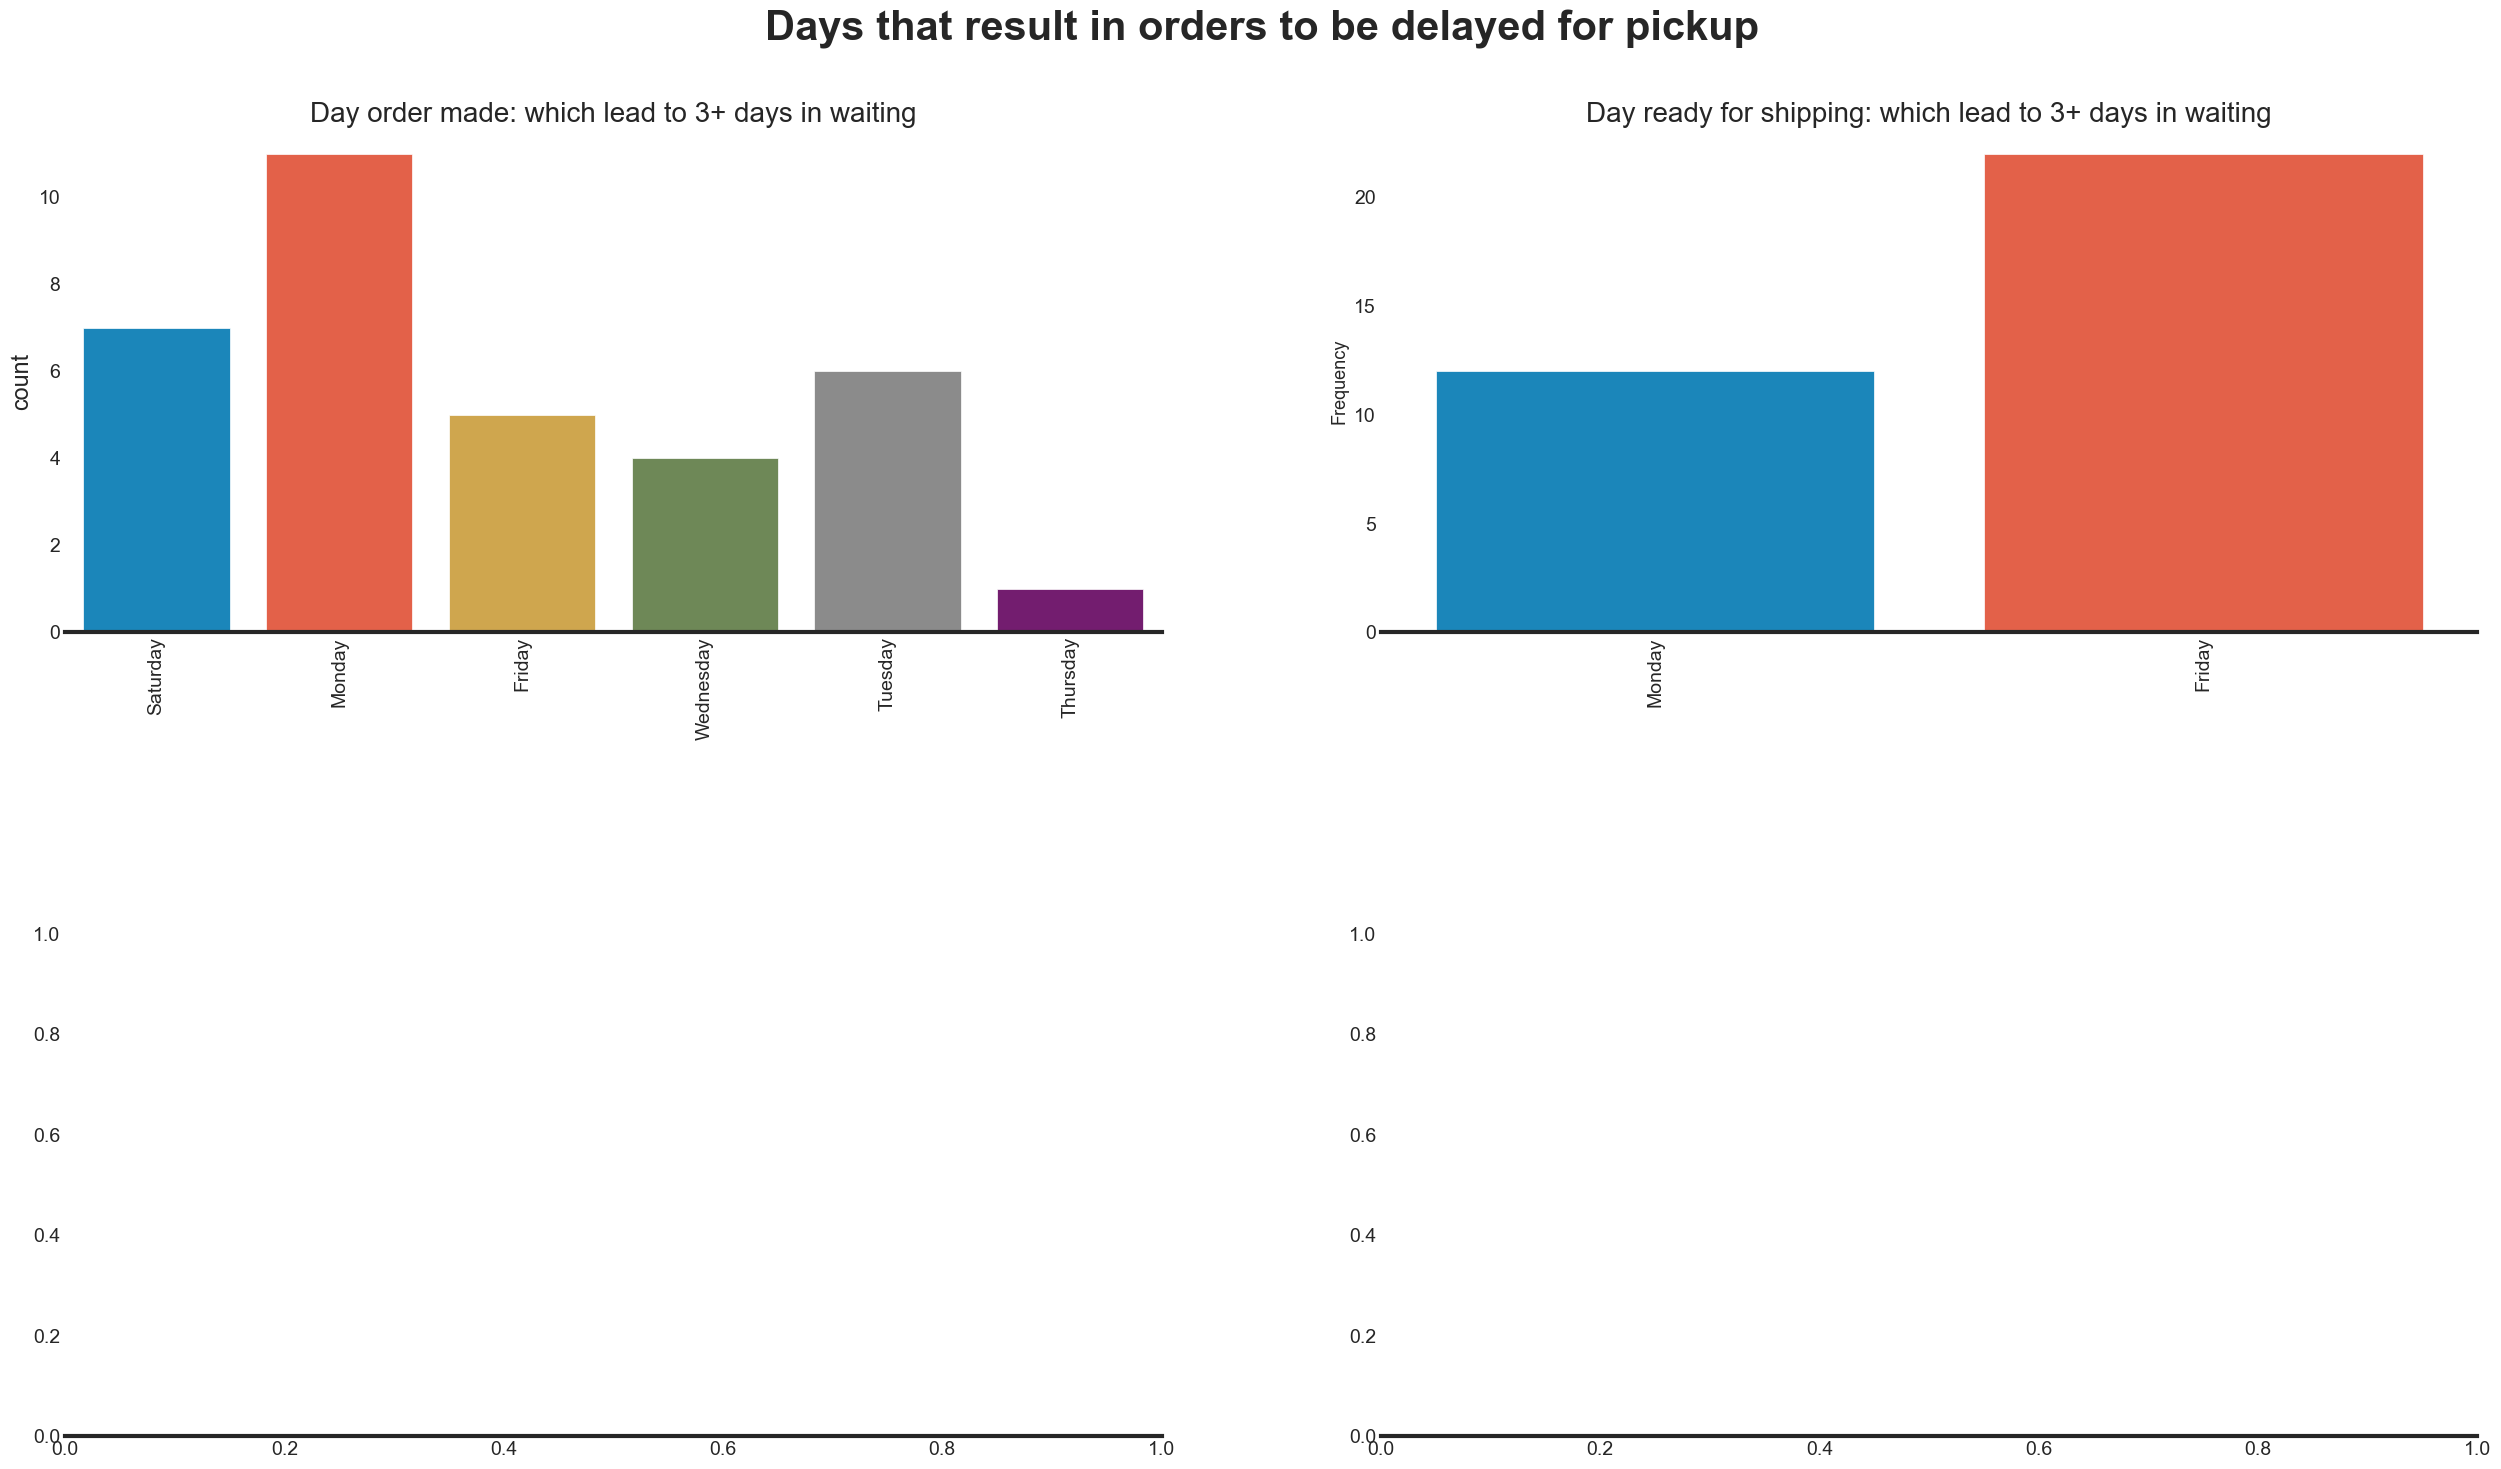

In [28]:
# Plot both charts side by side for Order Day and Ready Ship Day

fig, ax = plt.subplots(2,2, figsize=(25,15)) # create subplots on 2 rows and 2 columns
plt.suptitle('Days that result in orders to be delayed for pickup', fontsize=30, fontweight='bold') 
fig.tight_layout()   # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .6, wspace = .2, top = .9) # adjusts the space between the single subplots
sns.set_style("white")
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white', 'grid.color': 'white'})


f1 = sns.countplot(x=filt_pickup_waiting2['order_day'], ax=ax[0,0]) # creates barchart 
f1.tick_params(axis='x', labelrotation=90) # sets the label y-axis
f1.set(xlabel=None) # sets the x-axis label
f1.set_xlabel("", fontsize = 25) # limits the x-axis values from 0 to 1000000
f1.set_title('Day order made: which lead to 3+ days in waiting', fontsize=20); # set title;

f2 = sns.countplot(x=filt_pickup_waiting2['ready_ship_day'], ax=ax[0,1]) # creates barchart 
f2.tick_params(axis='x', labelrotation=90)
f2.set(xlabel=None)
f2.set_ylabel("Frequency", fontsize = 13)
f2.set_title('Day ready for shipping: which lead to 3+ days in waiting', fontsize=20); # set title

plt.savefig("pickup_waiting.png")  # Change the file extension as needed
;

### Regions most affected
West       12\
South      10\
East        9\
Central     3